In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
train_terms = pd.read_csv("Train/train_terms.tsv",sep="\t")
print(train_terms.shape)
train_terms.head()

(5363863, 3)


,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [3]:
train_protein_ids = np.load('train_ids.npy')
print(train_protein_ids.shape)
print(train_protein_ids[:5])

train_embeddings = np.load('train_embeds.npy')

# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)
train_df.head()

(142246,)
['P20536' 'O73864' 'O95231' 'A0A0B4J1F4' 'P54366']
(142246, 1024)


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


(31466,)


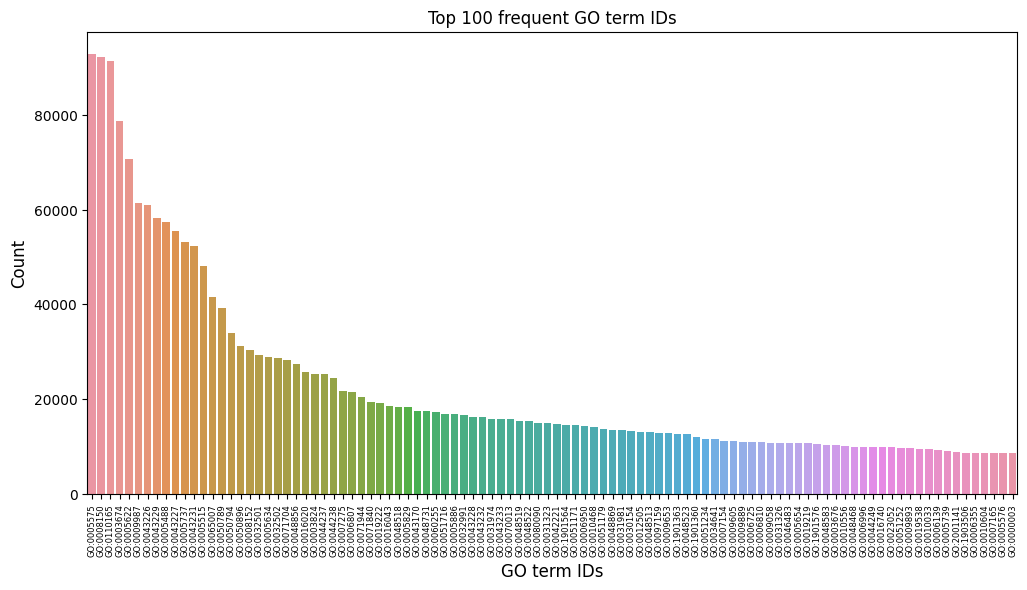

In [4]:
print(train_terms['term'].value_counts().shape)

# Select first 1500 values for plotting
plot_df = train_terms['term'].value_counts().iloc[:100]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

(3603814, 3)


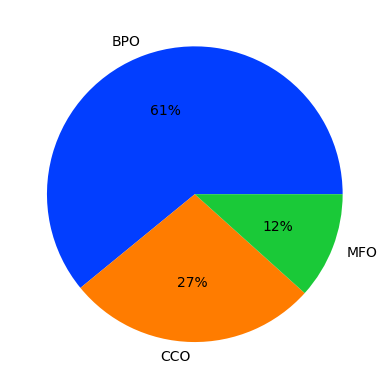

In [5]:
# Set the limit for label
num_of_labels = 500

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()

# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]
print(train_terms_updated.shape)

pie_df = train_terms_updated['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

In [6]:
# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 1500)
train_size = train_protein_ids.shape[0] # len(X)
train_labels = np.zeros((train_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(train_protein_ids)

# Loop through each label
for i in tqdm(range(num_of_labels)):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]

    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['EntryID'].unique()

    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)

# Convert train_Y numpy into pandas dataframe
labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)
labels_df.head()

100%|██████████| 500/500 [00:55<00:00,  8.99it/s]

(142246, 500)


,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0140657,GO:0044297,GO:0030659,GO:0051129,GO:0099568,GO:0044403,GO:0042803,GO:0016829,GO:0090596,GO:0051640
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
labels_df.head()

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0140657,GO:0044297,GO:0030659,GO:0051129,GO:0099568,GO:0044403,GO:0042803,GO:0016829,GO:0090596,GO:0051640
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [8]:
labels_df.to_csv('labels_df.csv')

In [9]:
labels_df

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0140657,GO:0044297,GO:0030659,GO:0051129,GO:0099568,GO:0044403,GO:0042803,GO:0016829,GO:0090596,GO:0051640
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142241,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142242,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142243,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142244,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


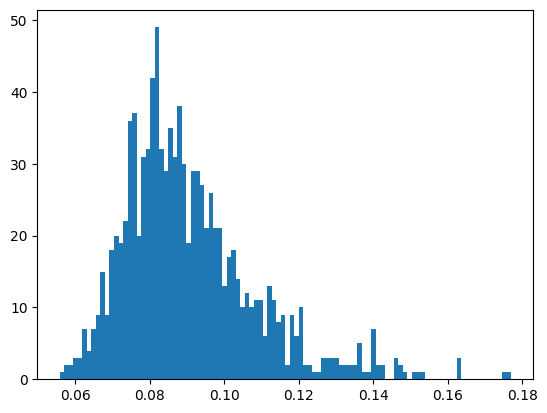

number of bad cols: 68
col numbers: [   2   14   23   33   35   64   73  145  147  149  167  168  189  190
  203  204  211  218  274  280  282  283  295  310  336  392  403  406
  437  438  444  462  471  501  512  522  524  526  538  569  590  592
  615  616  617  631  643  712  722  733  762  780  786  793  815  819
  836  838  846  898  899  914  948  954  967  976  993 1005]


In [10]:
corr = train_df.corr()
means_of_correlations = abs(corr).mean()
plt.hist(means_of_correlations,bins=100)
plt.show()
highly_correlated_cols= np.where(means_of_correlations>0.12)
print('number of bad cols:' ,len(highly_correlated_cols[0]))
print('col numbers:',(highly_correlated_cols[0]+1))

In [11]:
reduced_train_df = train_df.drop(train_df.columns[highly_correlated_cols], axis =1)
reduced_train_df.shape

(142246, 956)

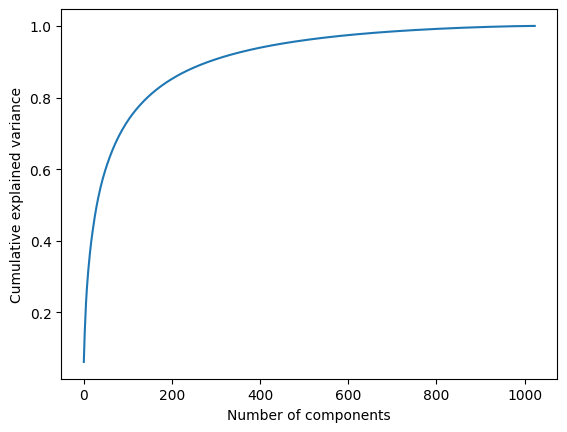

Number of components retained: 775
        Column_1  Column_2  Column_3  Column_4  Column_5  Column_6  Column_7   
0       0.855274 -1.143614  0.329238 -1.205032 -1.482482  1.268945 -0.496902  \
1      -1.895137  0.822708 -3.001527 -2.932059 -0.129563 -0.131645  0.125328   
2      -1.325879 -1.234988 -0.461254 -0.238241 -1.348293  1.653474 -0.251967   
3      -0.727342  0.871848 -0.443078  0.563338 -0.629256 -0.608213 -0.043475   
4      -0.116806  0.315372 -0.129522 -1.464012  0.253581 -0.242380  0.282852   
...          ...       ...       ...       ...       ...       ...       ...   
142241  0.532507  0.071589  0.140016  0.079146 -0.353572  0.119385  2.089929   
142242  1.195800  0.288340  0.028952  0.682395  0.112074 -0.214015  0.433817   
142243 -0.052106  0.475476 -0.593077 -0.448242 -1.196526  0.881329  0.325150   
142244  1.304483  1.083777  0.631499  1.379549  0.775597  0.164069  0.203753   
142245  0.142657  0.610469  1.483227 -0.899977  0.731214 -0.463900 -0.472294   

    

In [12]:
#PCA with threshold:
def apply_pca_with_threshold(data, threshold):
    # Standardize the features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Apply PCA
    pca = PCA()
    pca_result = pca.fit_transform(scaled_data)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.show()
    # Get the explained variance ratios
    explained_variance_ratio = pca.explained_variance_ratio_

    # Determine the number of components to retain based on the threshold
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    num_components = np.argmax(cumulative_explained_variance >= threshold) + 1

    # Fit PCA with the selected number of components
    pca_selected = PCA(n_components=num_components)
    pca_result_selected = pca_selected.fit_transform(scaled_data)

    # Transform the selected components back to the original space
    selected_features = pca_selected.inverse_transform(pca_result_selected)

    # Create a DataFrame with the selected features
    selected_df = pd.DataFrame(data=selected_features, columns=data.columns)

    # Identify the dropped columns
    dropped_columns = data.columns.difference(selected_df.columns)

    pca_threshold = pd.DataFrame(data=selected_features, columns=train_df.columns)

    return num_components, dropped_columns, pca_threshold

threshold = 0.99

# Apply PCA with the specified threshold
num_components_retained, dropped_columns, pca_threshold_df = apply_pca_with_threshold(train_df, threshold)
print("Number of components retained:", num_components_retained)
print(pca_threshold_df)



In [13]:
INPUT_SHAPE = [pca_threshold_df.shape[1]]
BATCH_SIZE = 5120
epochs = 200

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels,activation='sigmoid')
])


# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

history = model.fit(
    pca_threshold_df, labels_df,
    batch_size=BATCH_SIZE,
    epochs=epochs
)

Epoch 1/200
28/28 [==============================] - 4s 139ms/step - loss: 0.2493 - binary_accuracy: 0.9152 - auc: 0.7036
Epoch 2/200
28/28 [==============================] - 4s 142ms/step - loss: 0.1544 - binary_accuracy: 0.9523 - auc: 0.8286
Epoch 3/200
28/28 [==============================] - 4s 142ms/step - loss: 0.1427 - binary_accuracy: 0.9534 - auc: 0.8697
Epoch 4/200
28/28 [==============================] - 4s 146ms/step - loss: 0.1362 - binary_accuracy: 0.9542 - auc: 0.8884
Epoch 5/200
28/28 [==============================] - 4s 148ms/step - loss: 0.1324 - binary_accuracy: 0.9548 - auc: 0.8976
Epoch 6/200
28/28 [==============================] - 4s 145ms/step - loss: 0.1296 - binary_accuracy: 0.9553 - auc: 0.9037
Epoch 7/200
28/28 [==============================] - 4s 144ms/step - loss: 0.1274 - binary_accuracy: 0.9557 - auc: 0.9082
Epoch 8/200
28/28 [==============================] - 4s 154ms/step - loss: 0.1255 - binary_accuracy: 0.9561 - auc: 0.9121
Epoch 9/200
28/28 [=====

In [14]:
pred = model.predict(np.array(pca_threshold_df)[0][np.newaxis,...])
label  = np.array(labels_df)[0]
print(pred)
print(label)

1/1 [==============================] - 0s 110ms/step
[[7.89917186e-02 9.99811649e-01 2.89707026e-03 9.92298484e-01
  7.15673203e-04 9.99722242e-01 3.30865475e-07 1.78509538e-07
  7.84488738e-01 1.96251861e-07 2.86761764e-02 8.82372575e-08
  4.35675830e-01 2.27437494e-03 1.29131367e-03 8.37346015e-04
  2.37801254e-01 9.99982178e-01 5.14772751e-07 1.34370748e-06
  1.41376646e-07 9.99987841e-01 8.94344687e-09 1.37333445e-05
  8.28436732e-01 9.99993324e-01 9.99490380e-01 1.16708787e-09
  9.99997318e-01 9.10158633e-06 3.74590454e-04 2.74275080e-05
  2.45318253e-04 1.01257442e-03 7.10361823e-02 9.99970496e-01
  4.38544305e-11 2.51052334e-05 1.14352852e-01 2.46266069e-07
  2.30981596e-02 3.68317643e-08 3.18246336e-08 1.57684565e-09
  1.37561673e-09 1.68408487e-09 2.94507830e-04 1.91722298e-04
  3.21514926e-06 3.40792139e-05 1.95500528e-04 4.15295581e-05
  8.44404804e-06 5.76974750e-02 1.39139559e-06 5.90132943e-10
  9.87698812e-10 1.30371700e-10 2.60227812e-10 3.77375642e-09
  2.26477406e-10 

In [15]:
evaluation = model.evaluate(pca_threshold_df, labels_df)
accuracy = evaluation[1]  # binary_accuracy
print("Overall Accuracy:", accuracy)

4446/4446 [==============================] - 5s 1ms/step - loss: 0.0481 - binary_accuracy: 0.9817 - auc: 0.9893
Overall Accuracy: 0.9816582202911377
